## Load data

In [12]:
from dataAnalysis.DataAnalysis import DataAnalysis
import pandas as pd

data = pd.read_csv(r"extdata/sbcdata.csv", header=0)
data_analysis = DataAnalysis(data)

/home/dwalke/git/sbc/dataAnalysis/data/Filter.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']


Training: 
Assessable data are 528101 cases and 1015074 CBCs
Control data are 527038 cases and 1013548 CBCs
Sepsis data are 1488 cases and 1526 CBCs
$$$$$$$$$$$$$$$$$$$$
Testing: 


/home/dwalke/git/sbc/dataAnalysis/data/Filter.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']


Controls: 365794, Sepsis: 490
Assessable data are 180494 cases and 366284 CBCs
Control data are 180157 cases and 365794 CBCs
Sepsis data are 472 cases and 490 CBCs


/home/dwalke/git/sbc/dataAnalysis/data/Filter.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']


Controls: 437629, Sepsis: 448
Assessable data are 157922 cases and 438077 CBCs
Control data are 180157 cases and 437629 CBCs
Sepsis data are 438 cases and 448 CBCs


In [13]:
import torch

y_train = torch.tensor(data_analysis.get_y_train(), dtype=torch.long)
X_train = torch.tensor(data_analysis.get_X_train(), dtype=torch.float)

y_test = torch.tensor(data_analysis.get_y_test(), dtype=torch.long)
X_test = torch.tensor(data_analysis.get_X_test(), dtype=torch.float)

y_gw_test = torch.tensor(data_analysis.get_y_gw(), dtype=torch.long)
X_gw_test = torch.tensor(data_analysis.get_X_gw(), dtype=torch.float)

## Normalize and Concatenate data

In [14]:
def normalize(tensor):
    mean = torch.mean(tensor, dim = 0)
    std = torch.std(tensor, dim = 0)
    mean_diff = tensor - mean
    return mean_diff / std

X_train = normalize(X_train)
X_test = normalize(X_test)
X_gw_test = normalize(X_gw_test)

In [15]:
y_all = torch.concat((y_train, y_test, y_gw_test))
X_all = torch.concat((X_train, X_test, X_gw_test))

## Train/Validation/Test splits

In [16]:
def true_indices_like(tensor):
    return torch.ones((tensor.shape[0])).type(torch.bool)

def false_indices_like(tensor):
    return torch.zeros((tensor.shape[0])).type(torch.bool)

def split(train_features):
    tensor = true_indices_like(train_features)
    max_index = round(tensor.shape[0] * .8)
    train = torch.zeros(tensor.shape[0])
    train[:max_index] = 1
    
    val = torch.zeros(tensor.shape[0])
    val[max_index:] = 1
    return{
        "train": train.type(torch.bool),
        "val":val.type(torch.bool)
    }
train_data = split(X_train)

train_mask = torch.concat((train_data["train"], false_indices_like(X_test), false_indices_like(X_gw_test)))
val_mask = torch.concat((train_data["val"], false_indices_like(X_test), false_indices_like(X_gw_test)))
test_l_mask = torch.concat((false_indices_like(X_train), true_indices_like(X_test), false_indices_like(X_gw_test)))
test_gw_mask = torch.concat((false_indices_like(X_train), false_indices_like(X_test), true_indices_like(X_gw_test)))

## Construct edges and define graph

In [17]:
from torch_geometric.nn import knn_graph
from torch_geometric.data import Data

edge_index = knn_graph(X_all,k = 4, loop = True, num_workers = -1)
graph = Data(x= X_all,  edge_index = edge_index, y = y_all)

## Define model

In [18]:
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
import torch
from dataAnalysis.Constants import FEATURES

class GraphNeuralNetwork(torch.nn.Module):

    def __init__(self, hidden_dim = 128, out_channels = 1):
        super(GraphNeuralNetwork, self).__init__()
        
        input_dim = len(FEATURES)          
        self.conv1 = SAGEConv(input_dim, hidden_dim, normalize=True, project= True, aggr = "mean", root_weight = True, dropout=0.0)
        self.conv_end = SAGEConv(hidden_dim, out_channels, aggr = "mean", root_weight = True)


    def forward(self, graph):
        x, edge_index = graph.x, graph.edge_index
        x = torch.relu(self.conv1(x, edge_index))
        x = self.conv_end(x, edge_index)
        return x
            
    def predict_proba(self, graph, mask):
        with torch.inference_mode():
            self.eval()
            logits = self.forward(graph)
            scores = torch.sigmoid(torch.squeeze(logits[mask]))
            scores = torch.unsqueeze(scores, 0)
            proba_predict = torch.concat((1- scores, scores), dim = 0)
            return torch.transpose(proba_predict, 0, 1)
            
    def predict(self, graph, mask):
        return torch.round(self.predict_proba(graph, mask)[:, 1])

## Shift data to device

In [19]:
device = torch.device("cuda:2") if torch.cuda.is_available() else torch.device("cpu")

graph = graph.to(device)
WEIGHT = torch.tensor([664])
WEIGHT = WEIGHT.to(device)

print("Data shifted to the device " + str(device))

Data shifted to the device cuda:2


## Model-Wrapper class

In [20]:
import torch 

class ModelWrapper():
    def __init__(self, graph):
        self.LEARNING_RATE = 3e-4
        self.MAX_EPOCHS = 40000

        self.model = GraphNeuralNetwork(hidden_dim = 128, out_channels=1) 
        self.model = self.model.to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.LEARNING_RATE,betas=(0.9, 0.999), eps=1e-08)
        self.graph = graph
        
        self.last_loss = 0
        self.increased_loss = 0
        self.BREAKING_THRESHOLD = 10    
        self.val_loss = []
        self.train_loss = []
    
    def validate(self):
        with torch.inference_mode():
            self.model.eval()
            out = self.model(self.graph)
            loss = F.binary_cross_entropy_with_logits(torch.squeeze(out[val_mask]), self.graph.y[val_mask].type(torch.float32),
                                                      pos_weight=WEIGHT)
            self.val_loss.append(loss.item())
            if loss.item() > self.last_loss:
                self.increased_loss += 1
            else:
                self.increased_loss = 0
            self.last_loss = loss.item()

    def train(self):
        for epoch in range(self.MAX_EPOCHS):
            self.model.train()
            self.optimizer.zero_grad()
            out = self.model(self.graph)
            loss = F.binary_cross_entropy_with_logits(torch.squeeze(out[train_mask]), self.graph.y[train_mask].type(torch.float32),
                                                      pos_weight=WEIGHT)
            self.train_loss.append(loss.item())
            loss.backward()
            self.optimizer.step()
            self.validate() 

            if self.increased_loss >= self.BREAKING_THRESHOLD:
#                 print(f"Breaked at {str(epoch)}")
                break
            
    def get_model(self):
        return self.model    
    
    def plot_loss(self):
        plt.plot(self.epochs, self.train_loss, 'g', label='Training loss')
        plt.plot(self.epochs, self.val_loss, 'y', label='Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

In [21]:
model_wrapper = ModelWrapper(graph)
model_wrapper.train()
model = model_wrapper.get_model()

## Shift data and model back to CPU for evaluation

In [22]:
graph = graph.cpu()
model = model.cpu()

## Evaluation

In [23]:
from dataAnalysis.Metrics import Evaluation

evaluation = Evaluation(y_test.cpu(), y_gw_test.cpu(), X_test.cpu(), X_gw_test.cpu())
evaluation.set_test_args([graph, test_l_mask])
evaluation.set_gw_args([graph, test_gw_mask])

/home/dwalke/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


,Name,MCC,F1-Micro,F1-Macro,F1-Binary,AUROC,AUPRC
0,Leipzig,0.050833,0.786734,0.445117,0.009736,0.875149,0.019686
1,Greifswald,0.038271,0.803806,0.449053,0.006956,0.816976,0.006151


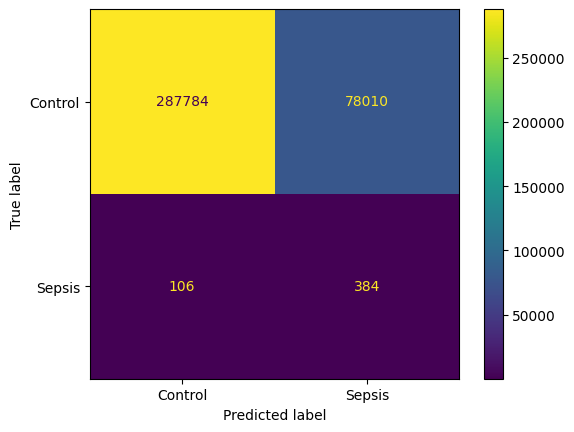

In [24]:
evaluation.plot_confusion_matrix(model)
evaluation.get_df_metrics(model)

## Error evaluation

In [11]:
import time

number_of_iter = 100
dataframes =[]
gnn_models = []
times = []
for i in range(number_of_iter):
#     print(i)
    graph = graph.to(device)
    start = time.time()
    model_wrapper = ModelWrapper(graph)
    model_wrapper.train()
    times.append(time.time()-start)
    print(time.time()- start)
#     model = model_wrapper.get_model()
#     model = model.cpu()
#     graph = graph.cpu()
#     df = evaluation.get_df_metrics(model)
#     print(df)
#     dataframes.append(df)
#     gnn_models.append(model)

301.03331232070923
381.25885128974915
471.0318374633789
574.0235753059387
501.4212076663971
583.9858245849609
426.7771816253662
417.3149857521057
395.57619309425354
346.1679060459137
518.0370142459869
307.4515497684479
385.0093193054199
312.0024094581604
298.898313999176
334.2507200241089
328.1577932834625
390.8201172351837
224.20103073120117
392.71542859077454
308.04603123664856
375.17196345329285
464.94070959091187
389.3446159362793
292.97766160964966
385.6959316730499
326.7365827560425
321.4758267402649
365.48416328430176
313.88329696655273
358.39200353622437
267.60297083854675
329.80824184417725
354.7811164855957
430.0589249134064
322.93155217170715
353.48855328559875
260.5352244377136
320.6003942489624
402.41185903549194
263.5186412334442
313.25879549980164
419.11292719841003
335.5307538509369
437.2727744579315
247.0999050140381
627.778635263443
366.85069966316223
541.6605565547943
504.5502698421478
451.12166929244995
311.1481742858887
613.2428810596466
246.77871704101562
331.5048

In [ ]:
for t in times:
    print(t)

In [ ]:
for df in dataframes:
    print(df)

## Maintain connection

In [ ]:
import time 
for i in range(60*24):
    print("Waiting")
    time.sleep(60)